# Отчет по работе с тензорными методами оптимизации
Сразу же проделаем начальные технические операции.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.python.ops.gradients_impl import _hessian_vector_product
from tqdm import tqdm

## Часть 0. Оборудование
Для расчетов будем использовать AMD Ryzen 2600X в качестве CPU и NVIDIA GeForce RTX 2070S в качестве GPU.

В качестве вычислительного фреймворка будем использовать TensorFlow. Он позволяет создавать графы вычислений и вычислять их внутри различных сессий. В рамках сессии сохраняются значения переменных в памяти TF. Сессия определяет вычислительное устройство.

Также будем использовать 16-ти битный float в качестве примитивного типа данных, потому что:
* Он занимает не так много места в памяти, как float32 и float64 (актуально в основном для GPU, так как память ограничена дизайном устройства).
* Производительность GPU тем выше, чем меньше битность примитивов (судя по [таблице на Википедии](https://en.wikipedia.org/wiki/List_of_Nvidia_graphics_processing_units#GeForce_20_series)).
* Наши данные можно отнормировать, чтобы они находились близко к единице, поэтому потеря точности и ограничения абсолютных значений из-за использования float16 в наших задачах несущественны.

Было установлено, что в первой части отчета при использовании float64 CPU выполняет вычисления быстрее GPU. При использовании float16 и float32 GPU обгоняет CPU. Более эта тема не затрагивается в отчете.

In [2]:
dtype = np.float16

## Часть 1. Сравнение времени вычисления автоградиента и произведения гессиана на вектор
В качестве первой части отчета мне было предложено сравнить время вычислений пары функций TensorFlow на разных размерностях логистической регрессии и устройствах.

Для этого я реализовал функцию для генерации данных для задачи логистической регрессии: нужно классифицировать только два класса, признаки первого класса находятся близко к нулю, а второго – близко к единице. Функция принимает количество генерируемых признаков и объектов.

Объявим функцию.

In [3]:
class_count = 2

def generate_two_classes_data(feature_count: int, object_count: int):
    """
    Generates two classes: the first class has features near 0, the second – near 1.
    :returns features (with bias=1 feature), answers
    """
    features = np.concatenate((
        np.random.normal(
            np.concatenate((
                np.zeros([object_count // 2, feature_count], dtype=dtype),
                np.ones([object_count - object_count // 2, feature_count], dtype=dtype)
            )),
            scale=0.1
        ),
        np.ones([object_count, 1], dtype=dtype)
    ), axis=1)

    answers = np.concatenate((
        np.concatenate((
            np.zeros([object_count // 2, 1], dtype=dtype),
            np.ones([object_count - object_count // 2, 1], dtype=dtype)
        )),
        np.concatenate((
            np.ones([object_count // 2, 1], dtype=dtype),
            np.zeros([object_count - object_count // 2, 1], dtype=dtype)
        ))
    ), axis=1)

    return features, answers

Пример: сгенерируем три объекта с двумя признаками.

In [4]:
f, a = generate_two_classes_data(feature_count=2, object_count=3)
print("Матрица признаков:")
print(f)
print("Матрица классов:")
print(a)

Матрица признаков:
[[-0.18033548  0.05002789  1.        ]
 [ 1.12243988  0.94705769  1.        ]
 [ 0.97358936  0.9668083   1.        ]]
Матрица классов:
[[0. 1.]
 [1. 0.]
 [1. 0.]]


Реализуем функцию для тестирования времени.

Она принимает матрицы признаков и ответов, сессию TensorFlow и количество тестов для усреднения.

Функция строит граф вычисления логистической регрессии и градиента с произведением гессиана на вектор. Далее производится прогрев: один раз вычисления происходят без учета времени. После этого функция запускает несколько одинаковых вычислений и усредняет их время.

В итоге функция возвращает среднее время вычисления градиента и произведения гессиана на вектор (в секундах).

In [5]:
def measure_time(features, answers, sess, avg_times):
    print(f"{datetime.now()}: Starting")

    with sess:
        x = tf.constant(features, dtype=dtype)
        y = tf.constant(answers, dtype=dtype)

        W = tf.Variable(tf.ones([feature_count + 1, class_count], dtype))

        predictions = tf.nn.softmax(tf.matmul(x, W))
        cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=predictions, labels=y)

        g = tf.gradients(cost, W)[0]
        h_vec_product = _hessian_vector_product(cost, [W], [W])[0]

        init = tf.variables_initializer([W])

        print(f"{datetime.now()}: Graph created")

        sess.run(init)

        print(f"{datetime.now()}: Variables initialized")

        # Прогрев:
        sess.run(g, feed_dict={x: features, y: answers})
        sess.run(h_vec_product, feed_dict={x: features, y: answers})

        print(f"{datetime.now()}: Warm-up completed")

        g_deltas = []
        h_vec_deltas = []

        for i in range(avg_times):
            start = datetime.now().timestamp()
            sess.run(g, feed_dict={x: features, y: answers})
            g_deltas.append(datetime.now().timestamp() - start)

            start = datetime.now().timestamp()
            sess.run(h_vec_product, feed_dict={x: features, y: answers})
            h_vec_deltas.append(datetime.now().timestamp() - start)

        g_delta = sum(g_deltas) / len(g_deltas)
        h_vec_delta = sum(h_vec_deltas) / len(h_vec_deltas)

        print(f"{datetime.now()}: Completed")

        return g_delta, h_vec_delta

Запустим наши бенчмарки. Усредним время трех вычислений. Выведем таблицу с результатами.

In [6]:
times = 3

stats = pd.DataFrame(columns=[
    "Feature Count",
    "GPU: Gradient Avg Time (secs)", "GPU: H-Vec Product Avg Time (secs)",
    "CPU: Gradient Avg Time (secs)", "CPU: H-Vec Product Avg Time (secs)",
])

for feature_count in (10**2, 10**3, 10**4, 10**5, 10**6):
    object_count = 5

    features, answers = generate_two_classes_data(feature_count=feature_count, object_count=object_count)

    print(f"Features: {feature_count}, CPU:")
    g_delta_cpu, h_vec_delta_cpu = measure_time(features, answers, tf.Session(config=tf.ConfigProto(device_count={"GPU": 0})), times)

    print(f"Features: {feature_count}, GPU:")
    g_delta_gpu, h_vec_delta_gpu = measure_time(features, answers, tf.Session(), times)

    stats.loc[len(stats)] = [feature_count, g_delta_gpu, h_vec_delta_gpu, g_delta_cpu, h_vec_delta_cpu]

stats

Features: 100, CPU:
2020-06-13 19:35:43.688237: Starting
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2020-06-13 19:35:43.765234: Graph created
2020-06-13 19:35:43.776235: Variables initialized
2020-06-13 19:35:43.840246: Warm-up completed
2020-06-13 19:35:43.843247: Completed
Features: 100, GPU:
2020-06-13 19:35:44.544394: Starting
2020-06-13 19:35:44.603392: Graph created
2020-06-13 19:35:44.856394: Variables initialized
2020-06-13 19:35:45.206395: Warm-up completed
2020-06-13 19:35:45.213393: Completed
Features: 1000, CPU:
2020-06-13 19:35:45.218395: Starting
2020-06-13 19:35:45.287392: Graph created
2020-06-13 19:35:45.310392: Variables initialized
2020-06-13 19:35:45.387393: Warm-up completed
2020-06-13 19:35:45.392393: Completed
Features: 1000, GPU:
2020-06-13 19:35:45.399450: Starting
2020-06-13 19:35:45.511402: Graph created
2020-06-13 19:35:45.543404: Variables initialized
2020-06-13 19:35:45.645401: Warm-up completed
2020-06-13

,Feature Count,GPU: Gradient Avg Time (secs),GPU: H-Vec Product Avg Time (secs),CPU: Gradient Avg Time (secs),CPU: H-Vec Product Avg Time (secs)
0,100.0,0.001000,0.001000,0.001000,0.000000
1,1000.0,0.001000,0.001001,0.000667,0.000667
2,10000.0,0.001334,0.001000,0.003667,0.004666
3,100000.0,0.003335,0.002999,0.008335,0.007903
4,1000000.0,0.030667,0.030666,0.063001,0.069666


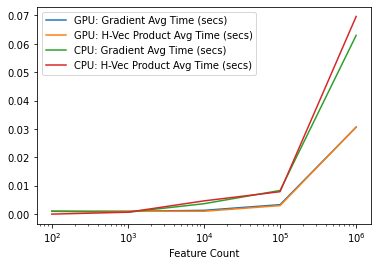

In [9]:
stats.plot(x="Feature Count", logx=True)
plt.show()

Сразу же построили график. Выводы из графика:
* Время вычисления градиента и произведения гессиана на вектор сравнимо.
* На больших размерностях GPU показывает заметное преимущество по скорости вычислений.

Также можно сделать вывод по логированию: копирование данных из памяти в TF занимает намного больше времени, чем вычисления.

## Часть 2. Кубическая модель
В качестве второй части отчета мне было предложено реализовать вычисление формулы 2.4 из документа <https://link.springer.com/content/pdf/10.1007/s10107-006-0706-8.pdf> и сравнить время вычислений на разных устройствах.

Предлагалось в качестве функции $f$ использовать логистическую регрессию для данных MNIST, а также сократить автоматические вычисления градиента, по возможности вычислив его аналитически на максимальную глубину.

Далее перепишем задачу, используя более близкие к логистической регрессии обозначения.

$Arg \ min_y [scalarProd(f'(x), y-x) + \frac{1}{2} \cdot scalarProd(f''(x)(y-x), y-x) + \frac{M}{6} ||y-x||^3]$ – решаем спуском.

$y$ – текущие веса, размерность `[featureCount + 1, clsCount]` (`+ 1` из-за добавления `bias` признака). Заменяем на $W$.

$Arg \ min_W [scalarProd(f'(x), W-x) + \frac{1}{2} \cdot scalarProd(f''(x)(W-x), W-x) + \frac{M}{6} ||W-x||^3]$

$x$ – константа с весами, размерность `[featureCount + 1, clsCount]` (`+ 1` из-за добавления `bias` признака). Заменяем на $W_k$.

$Arg \ min_W [scalarProd(f'(W_k), W-W_k) + \frac{1}{2} \cdot scalarProd(f''(W_k)(W-W_k), W-W_k) + \frac{M}{6} ||W-W_k||^3]$

$f$ – заменяем на $cost$.

$Arg \ min_W [scalarProd(cost'_W(W_k), W-W_k) + \frac{1}{2} \cdot scalarProd(cost''_W(W_k)(W-W_k), W-W_k) + \frac{M}{6} ||W-W_k||^3]$

Меняем $cost''_W(W_k)(W-W_k)$ на $hVecProd$.

$Arg \ min_W [scalarProd(cost'_W(W_k), W-W_k) + \frac{1}{2} \cdot scalarProd(hVecProd(cost, W, W-W_k)(W_k), W-W_k) + \frac{M}{6} ||W-W_k||^3]$

Прописываем точный вызов градиента.

$Arg \ min_W [scalarProd(gradient(cost, W)(W_k), W-W_k) + \frac{1}{2} \cdot scalarProd(hVecProd(cost, W, W-W_k)(W_k), W-W_k) + \frac{M}{6} ||W-W_k||^3]$

$scalarProd$ трактуем как сумму поэлементных перемножений матриц, норма – корень из суммы квадратов элементов матрицы.

Как видим, на каждом шаге нужно брать градиент суммы из трех слагаемых:

$target = scalarProd(gradient(cost, W)(W_k), W-W_k) + \frac{1}{2} \cdot scalarProd(hVecProd(cost, W, W-W_k)(W_k), W-W_k) + \frac{M}{6} ||W-W_k||^3$

Нужно: $target\_g = gradient(target, W)$

Вычислим градиенты слагаемых аналитически (сделаем важное упоминание: TF способен проводить вычисления и без этого преобразования, пример можно найти в истории версий файла [hessian-vector-product-mnist.ipynb](https://github.com/SerVB/tensor-methods/blob/master/hessian-vector-product-mnist.ipynb)).

**Слагаемое 1**:

Для краткости заменим $C = gradient(cost, W)(W_k)$.

$target\_1\_g = gradient(scalarProd(C, W-W_k), W) = \dots$

i-тый элемент в результате $= \frac{d \ scalarProd(C, W-W_k)}{d \ W[i]} =$

$= \frac{d \ \sum_j C[j] \cdot (W-W_k)[j]}{d \ W[i]} =$

$= \frac{d \ \sum_j C[j] \cdot W[j]}{d \ W[i]} =$

$= \frac{d \ C[i] \cdot W[i]}{d \ W[i]} =$

$= C[i]$

$\dots = C$

**Слагаемое 2**:

Для краткости заменим $f(W) = hVecProd(cost, W, W-W_k)(W_k)$.

$target\_2\_g = gradient(scalarProd(f(W), W-W_k), W) = \dots$

i-тый элемент в результате $= \frac{d \ scalarProd(f(W), W-W_k)}{d \ W[i]} =$

$= \frac{d \ \sum_j f(W)[j] \cdot (W-W_k)[j]}{d \ W[i]} =$

$= \frac{d \ f(W)[i] \cdot (W-W_k)[i]}{d \ W[i]} =$

$= \frac{d \ f(W)[i]}{d \ W[i]} \cdot (W-W_k)[i]  + f(W)[i]$

$\dots = gradient(f(W), W) \cdot (W - W_k) + f(W)$

**Слагаемое 3**:

$target\_3\_g = gradient(\frac{M}{6} || W - W_k||^3, W) = \dots$

i-тый элемент в результате $= \frac{d \ \frac{M}{6} || W - W_k||^3}{d \ W[i]} =$

$= \frac{M}{6} \frac{d \ (\sum^n_{j=1}(W[j] - W_k[j])^2)^{\frac{3}{2}}}{d \ W[i]}=$

$= \frac{M}{6} \frac{3}{2} (\sum^n_{j=1}(W[j] - W_k[j])^2)^{\frac{1}{2}} \frac{d(W[i]-W_k[i])^2}{d \ W[i]}=$

$= \frac{M}{6} \frac{3}{2} ||W-W_k|| 2 (W[i]-W_k[i])=$

$= \frac{M}{2} ||W-W_k|| (W[i]-W_k[i])$

$\dots = \frac{M}{2} ||W-W_k|| (W-W_k)$

**Итог**:

$target\_g = target\_1\_g + target\_2\_g + target\_3\_g$.

Как видим, наши преобразования убрали вычисления скалярного произведения.

Начнем программировать!

In [3]:
# Готовим картинки:

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255
test_images = test_images / 255

feature_count = train_images.shape[1] * train_images.shape[2]
class_count = len(set(train_labels))

In [4]:
# Объявим функции для преобразования картинок в тензоры:

def result_vector(labels, object_ids):
    class_ids = labels[object_ids]
    answer = np.zeros((len(object_ids), class_count), dtype=dtype)

    for i in range(len(object_ids)):
        answer[i][class_ids[i]] = 1
    return answer

def feature_vector(images, object_ids):
    flatten = images[object_ids].reshape((len(object_ids), feature_count))
    return np.append(flatten, np.ones((len(object_ids), 1)), axis=1)  # add bias feature

In [5]:
# И функцию для получения партии для обучения:

batch_size = 300

def get_random_samples_x_y():
    object_ids = random.sample(range(len(train_images)), batch_size)
    return feature_vector(train_images, object_ids), result_vector(train_labels, object_ids)

In [6]:
# Функции для тестирования модели:

def get_test_data():
    object_ids = np.arange(len(test_images))
    return feature_vector(test_images, object_ids), result_vector(test_labels, object_ids)

test_features, test_answers = get_test_data()

def calc_accuracy(predictions, x, sess):
    predictions_count = len(test_images)
    predicted = sess.run(predictions, feed_dict={x: test_features})
    correct = sum(np.argmax(predicted, axis=1) == np.argmax(test_answers, axis=1))

    return correct / predictions_count

In [7]:
# Сформируем функцию для обучения логистической регрессии:

step_factor = 0.001
M_value = 6  # Возьмем 6 для тестов, но можем подставить любое число

maximum_steps = 10  # Количество шагов для нахождения Arg min
maximum_major_steps = 70  # Количество нахождений Arg min

def fit_regression(sess):
    print(f"{datetime.now()}: Starting")

    with sess:
        x = tf.placeholder(dtype, [None, feature_count + 1], name="x")
        y = tf.placeholder(dtype, [None, class_count], name="y")

        M = tf.constant(M_value, dtype, name="M")

        W_k = tf.Variable(tf.zeros([feature_count + 1, class_count], dtype), name="W_k")
        W = tf.Variable(tf.zeros([feature_count + 1, class_count], dtype), name="W")

        predictions = tf.nn.softmax(tf.matmul(x, W_k))
        cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=predictions, labels=y)

        g = tf.gradients(cost, W_k)[0]
        h_vec_prod = _hessian_vector_product(cost, [W_k], [W - W_k])[0]

        # Заметим, что градиент от cost не меняется в пределах одного нахождения Arg min,
        # поэтому вынесем его в переменную и будем вычислять это значение во внешнем цикле:
        g_value = tf.Variable(tf.zeros([feature_count + 1, class_count], dtype), name="g_value")
        update_g_value = g_value.assign(g)

        target_0_g = g_value
        target_1_g = 0.5 * (tf.gradients(h_vec_prod, W_k)[0] * (W - W_k) + h_vec_prod)
        target_2_g = M / 2 * tf.norm(W - W_k) * (W - W_k)
        target_g = target_0_g + target_1_g + target_2_g

        update_W = W.assign_sub(step_factor * target_g)

        update_W_k = W_k.assign(W)

        init = tf.variables_initializer([W_k, W, g_value])

        print(f"{datetime.now()}: Graph created")

        sess.run(init)

        print(f"{datetime.now()}: Variables initialized")

        with tqdm(total=maximum_major_steps * maximum_steps) as pbar:
            for major_steps in range(maximum_major_steps):
                features, answers = get_random_samples_x_y()
                sess.run(update_g_value, feed_dict={x: features, y: answers})

                for steps in range(maximum_steps):
                    sess.run(update_W, feed_dict={x: features, y: answers})
                    pbar.update(1)

                sess.run(update_W_k)

        accuracy = calc_accuracy(predictions=predictions, x=x, sess=sess)

        print(f"{datetime.now()}: Completed, accuracy = {accuracy}")

In [8]:
# Запустим:

print("CPU:")
fit_regression(tf.Session(config=tf.ConfigProto(device_count={"GPU": 0})))
print("GPU:")
fit_regression(tf.Session())

CPU:
2020-06-14 03:55:47.243986: Starting
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2020-06-14 03:55:47.680544: Graph created
2020-06-14 03:55:47.746542: Variables initialized
2020-06-14 03:56:29.205945: Completed, accuracy = 0.8927
GPU:
2020-06-14 03:56:30.867873: Starting
2020-06-14 03:56:31.212870: Graph created
2020-06-14 03:56:31.875612: Variables initialized
2020-06-14 03:56:36.838734: Completed, accuracy = 0.8862


100%|██████████| 700/700 [00:04<00:00, 144.42it/s]


Как видим, оба варианта показывают сравнимый процент правильных ответов на тестовой выборке. Однако скорость обучения на GPU примерно на порядок быстрее (41 секунда против четырех секунд).

Таким образом, можно утверждать, что использование GPU для тензорных методов оптимизации оправдано.